<a href="https://colab.research.google.com/github/rtheman/TimeSeries/blob/master/ARIMA_pmdarima_Covid19_USA_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA

Inspired by https://alkaline-ml.com/pmdarima/usecases/sun-spots.html#fitting-a-baseline

**Dataset**: COVID-19 Active Cases of California, 🇺🇸 (USA) from https://www.worldometers.info/coronavirus/

**REF**
- Matplotlib https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.00-Introduction-To-Matplotlib.ipynb#scrollTo=nQVfJzSfxBre

# 1.) Init. Environments & Libraries

In [ ]:
import pandas as pd
import numpy as np

! pip install pmdarima

     |████████████████████████████████| 1.5MB 3.0MB/s 


## a. Mount Google Drive (G-Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/g_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/g_drive


## b. Connect Google Cloud Storage (GCS)

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

Paramaterize Project ID and Bucket Name

In [ ]:
# project_id = 'rleung-sandbox'
# bucket_name = 'samples_data'

# 2.) Download Data

## a. from G-Drive

Init. Parameters

In [ ]:
data_URL = "./g_drive/My Drive/Colab Notebooks/data/_Samples/"
data_FileName = "COVID19_Active_Cases_CA.csv"
path = data_URL + data_FileName

Ingest data from G-Drive

In [ ]:
df = pd.read_csv(path, parse_dates=['Dates'], index_col='Dates')
df.tail()

,Active_Cases
Dates,
2020-04-29,41382
2020-04-30,43006
2020-05-01,44793
2020-05-02,46201
2020-05-03,47525


# 3.) Explore Data

Inspired by https://alkaline-ml.com/pmdarima/usecases/sun-spots.html#fitting-a-baseline

In [ ]:
import pandas.util.testing as tm
import pmdarima as pm
from pmdarima.datasets import load_sunspots
from pmdarima.model_selection import train_test_split
print(f"Using pmdarima {pm.__version__}")
# Using pmdarima 1.6.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


Using pmdarima 1.6.0


## a. Split dataset into Training and Validation

Take last 7-days as Validation dataset, leaving 70-days as Testing dataset.

In [ ]:
valid_len = 7
train_len = len(df) - valid_len
y_train, y_vali = train_test_split(df, train_size=train_len)
y_train.tail()

,Active_Cases
Dates,
2020-04-22,31569
2020-04-23,32675
2020-04-24,34299
2020-04-25,35879
2020-04-26,37232


## b. Visualize dataset

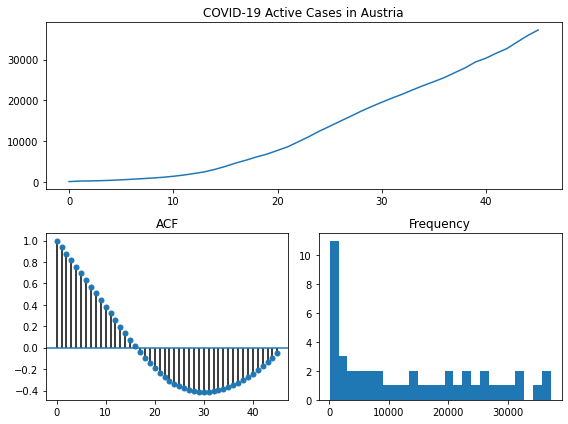

In [ ]:
from pmdarima.utils import tsdisplay

tsdisplay(y_train, lag_max=train_len-1, title="COVID-19 Active Cases in Austria", show=True)

Looking at the histogram. It is very zero-inflated. A lot of the statistical techniques used in time series modeling behave better when the data is **normally distributed**, so this may be something to look into.

# 4.) Fitting a baseline model

Before we start manipulating our data, let’s examine what would happen if we just fit a model straight out of the box:

In [ ]:
fit_base = pm.auto_arima(
    y_train,
    trace=True,
    suppress_warnings=True
)

print(fit_base.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=561.704, BIC=572.409, Time=0.309 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=574.940, BIC=578.508, Time=0.008 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=568.310, BIC=573.662, Time=0.042 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=570.118, BIC=575.471, Time=0.065 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=574.247, BIC=576.031, Time=0.008 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=561.462, BIC=570.383, Time=0.127 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=571.879, BIC=579.016, Time=0.082 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=567.762, BIC=574.898, Time=0.171 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=558.009, BIC=568.714, Time=0.263 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=555.537, BIC=564.458, Time=0.214 seconds
Near non-invertible roots for order (0, 2, 3)(0, 0, 0, 0

# 5.) Transform Data

Since we expect our model to perform better over more normal data, let’s experiment with (1.) Log transformations and the (2.) [Box-Cox transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation), each of which is provided as an endogenous transformer in the Pmdarima package.

## Log Transformation

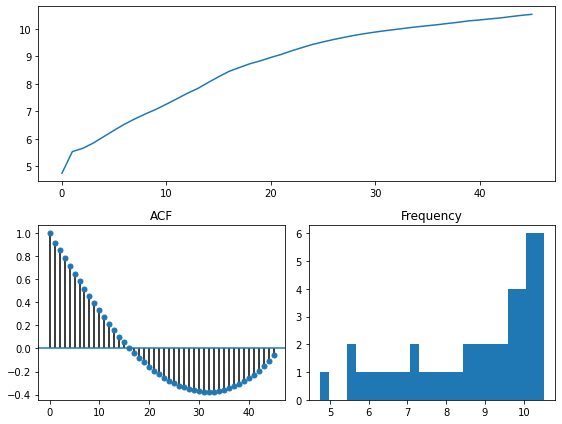

In [ ]:
from pmdarima.preprocessing import LogEndogTransformer

y_train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(y_train)
tsdisplay(y_train_log, lag_max=train_len-1)

In [ ]:
from scipy.stats import normaltest
normaltest(y_train_log)[1]

0.05969526201162195

## Box-Cox transformation

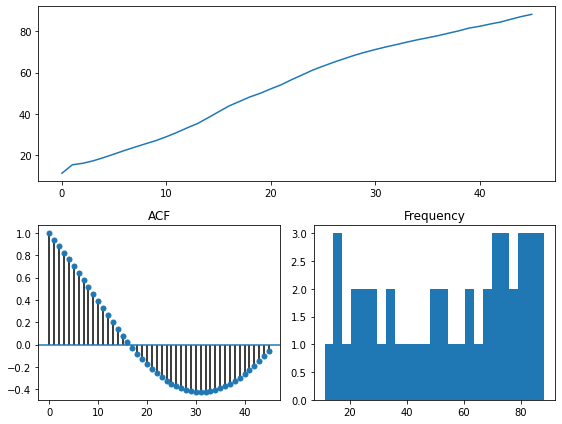

In [ ]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y_train)
tsdisplay(y_train_bc, lag_max=train_len-1)

In [ ]:
normaltest(y_train_bc)[1]

0.00011349285815538675

# 6.) Fitting a transformed model

Pmdarima implements a scikit-learn-esque pipeline used to chain transformations and estimators together. Using this, we can centralize the entire transformer/model fit into one metaestimator:

## a. Log Transformation

In [ ]:
from pmdarima.pipeline import Pipeline

fit_log = Pipeline([
    ('log', LogEndogTransformer(lmbda=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True
                           )
    )
])

fit_log.fit(y_train)

print(fit_log.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=-79.494, BIC=-68.789, Time=0.423 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=-72.440, BIC=-68.871, Time=0.072 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=-76.298, BIC=-70.945, Time=0.182 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=-81.076, BIC=-75.723, Time=0.241 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=-73.212, BIC=-71.427, Time=0.011 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=-83.271, BIC=-76.134, Time=0.178 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=-82.329, BIC=-73.408, Time=0.300 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=-77.245, BIC=-68.324, Time=0.225 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=-81.789, BIC=-74.652, Time=0.390 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=-80.412, BIC=-73.275, Time=0.217 seconds
Total fit time: 2.249 seconds
                          

## b. Box-Cox Transformation

In [ ]:
fit_boxcox = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True
                           )
    )
])

fit_boxcox.fit(y_train)

print(fit_boxcox.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=79.259, BIC=89.964, Time=0.339 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=79.719, BIC=83.287, Time=0.017 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=77.626, BIC=82.979, Time=0.051 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=76.193, BIC=81.546, Time=0.061 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=78.354, BIC=80.139, Time=0.009 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=76.434, BIC=83.571, Time=0.196 seconds
Near non-invertible roots for order (1, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=78.168, BIC=85.304, Time=0.078 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=80.019, BIC=88.940, Time=0.160 seconds
Total fit time: 0.921 seconds
                           Statespace Model Results             

# 7.) Forecast

Forecast the next 7-days

In [ ]:
# Forecast
import numpy as np

model = fit_base
forecast, conf_int = model.predict(n_periods=valid_len, return_conf_int=True)
print("\nForecasts:")
print(forecast)


Forecasts:
[38497.52329315 39630.16948443 41007.90843526 42412.62993695
 43844.33398949 45303.02059288 46788.68974713]


## a. Visualize Forecast

### Set-up Plots

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

! pip install mplcursors
import mplcursors

%matplotlib inline

plt.figure()  # create a plot figure
mpl.rcParams['figure.figsize'] = (20, 15)

<Figure size 432x288 with 0 Axes>

### Visualize Goodness of Fit

In [ ]:
# Visualize goodness of fit
in_sample_forecast, in_sample_confint = model.predict_in_sample(exogenous=None, return_conf_int=True)

### Actual vs. Forecast w/ Test Dataset

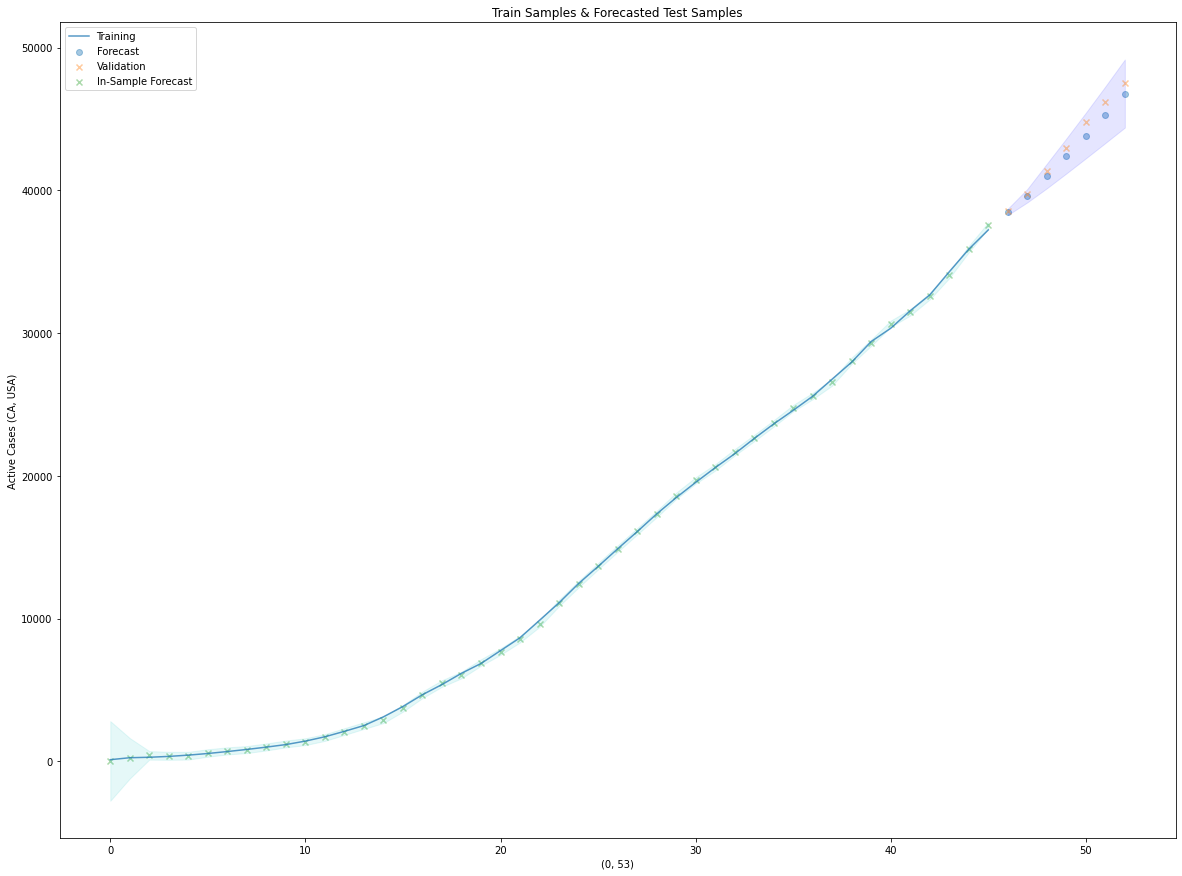

In [ ]:
# Now plot the results and the forecast for the test set
x_axis = np.arange(y_train.shape[0] + forecast.shape[0])

# Training data
plt.plot(x_axis[:y_train.shape[0]], y_train, alpha=0.75, label='Training')
# Forecast from ARIMA model
plt.scatter(x_axis[y_train.shape[0]:], forecast, alpha=0.4, marker='o', label='Forecast')
plt.fill_between(x_axis[-forecast.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')
# Validation data
plt.scatter(x_axis[y_train.shape[0]:], y_vali, alpha=0.4, marker='x', label='Validation')
# In-Samples Forecast
plt.scatter(x_axis[:in_sample_forecast.shape[0]], in_sample_forecast, alpha=0.4, marker='x', label="In-Sample Forecast")
plt.fill_between(x_axis[:in_sample_forecast.shape[0]], in_sample_confint[:, 0], in_sample_confint[:, 1], alpha=0.1, color='c')

plt.title('Train Samples & Forecasted Test Samples')
plt.legend()
plt.xlabel((0, x_axis.shape[0]))
plt.ylabel('Active Cases (CA, USA)')
mplcursors.cursor(hover=True)
# mplcursors.cursor()

### Comparison btw Actuals & Forecast

In [ ]:
df_fcast = y_vali.copy()
df_fcast['Forecast'] = forecast
df_fcast['difference'] = df_fcast['Forecast'] - df_fcast['Active_Cases']
df_fcast

,Active_Cases,Forecast,difference
Dates,,,
2020-04-27,38569,38497.523293,-71.476707
2020-04-28,39781,39630.169484,-150.830516
2020-04-29,41382,41007.908435,-374.091565
2020-04-30,43006,42412.629937,-593.370063
2020-05-01,44793,43844.333989,-948.666011
2020-05-02,46201,45303.020593,-897.979407
2020-05-03,47525,46788.689747,-736.310253


## b. Update Forecast

### Add the actual samples (validation dataset) to the model and crate NEW forecast

In [ ]:
fit_base.update(y_vali)

model = fit_base

new_forecast, new_conf_int  = model.predict(n_periods=valid_len, return_conf_int=True)
print("\nNew Forecast:")
print(new_forecast)


New Forecast:
[48652.22000525 49957.19273137 51415.86995939 52901.52902684
 54414.16993373 55953.79268006 57520.39726582]


### Actual vs (New) Forecast

Text(0, 0.5, 'Active Cases (CA, USA)')

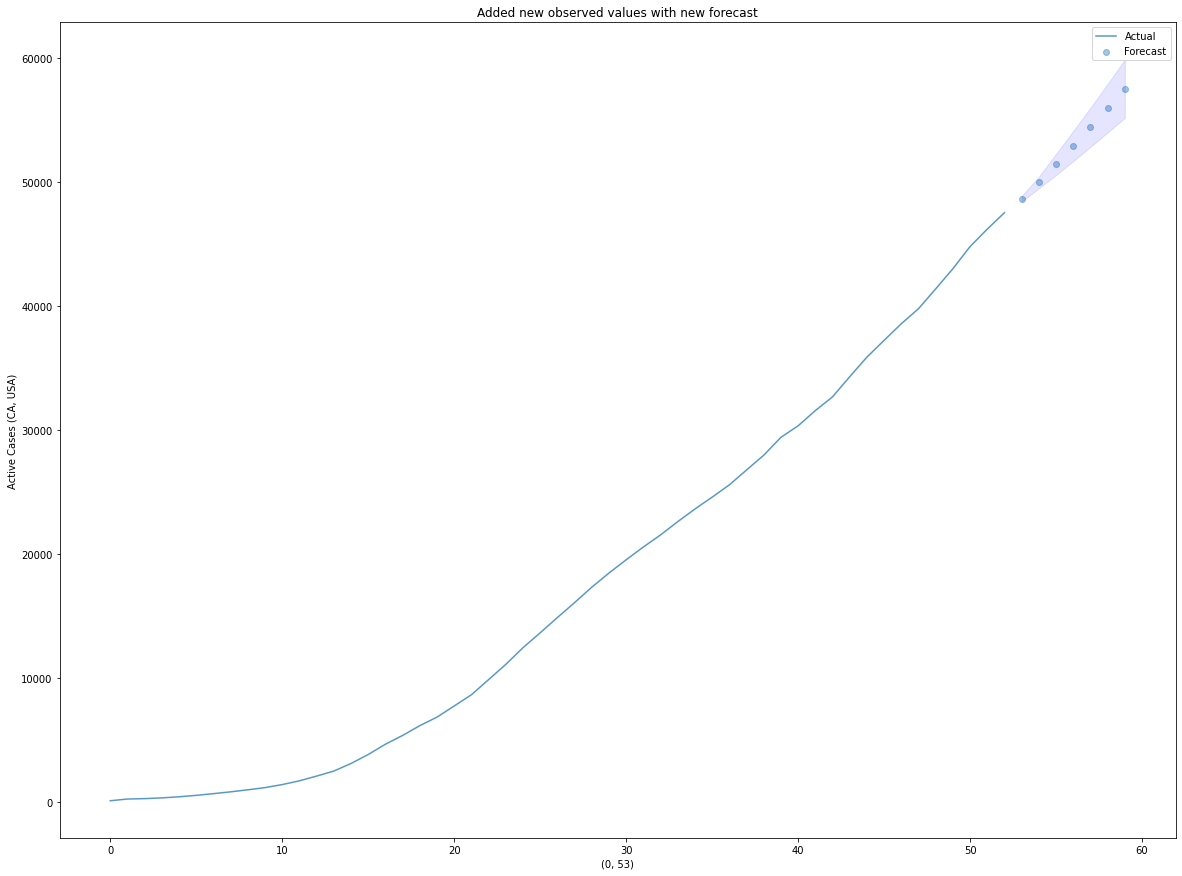

In [ ]:
# Now Plot results and the new forecast
new_x_axis = np.arange(df.shape[0] + valid_len)

# Training (Actual) data
plt.plot(new_x_axis[:df.shape[0]], df, alpha=0.75, label='Actual')
# New Forecast data
plt.scatter(new_x_axis[df.shape[0]:], new_forecast, alpha=0.4, marker='o', label='Forecast')
plt.fill_between(new_x_axis[-forecast.shape[0]:], new_conf_int[:, 0], new_conf_int[:, 1], alpha=0.1, color='b')

plt.title('Added new observed values with new forecast')
plt.legend()
plt.xlabel((0, x_axis.shape[0]))
plt.ylabel('Active Cases (CA, USA)')

In [ ]:
import datetime

start_date = df.index[-1]
start_date += datetime.timedelta(days=1)

df_forecast_index = pd.date_range(start_date, periods=7, freq='D')
# df_forecast_index

data = {'Active_Cases':new_forecast}
# data

df_forecast = pd.DataFrame(data, index = df_forecast_index)
df_forecast

,Active_Cases
2020-05-04,48652.220005
2020-05-05,49957.192731
2020-05-06,51415.869959
2020-05-07,52901.529027
2020-05-08,54414.169934
2020-05-09,55953.792680
2020-05-10,57520.397266
